## U-net for Cellular Segmentation

In [1]:
from __future__ import print_function

from matplotlib import pyplot as plt
from keras import losses
import os
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
import cv2
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls 'gdrive/My Drive/Colab Notebooks/Unet/train'

In [0]:
# training data 
image_location = "gdrive/My Drive/Colab Notebooks/Unet/"
image = image_location+"train/image"
label = image_location +"train/label"
test = image_location +"test"

In [0]:
class train_data():
    
    def __init__(self, image, label):
        self.image = []
        self.label = []
        for file in os.listdir(image):
            if file.endswith(".tif"):
                self.image.append(cv2.imread(image+"/"+file,0))
        
        for file in os.listdir(label):
            if file.endswith(".tif"):
                #print(label+"/"+file)
                self.label.append(cv2.imread(label+"/"+file,0))
    
    def get_image(self):
        return np.array(self.image[:int(len(self.image)/2)])

    def get_label(self):
        return np.array(self.label[:int(len(self.image)/2)])
    
    def get_validation_image(self):
        return np.array(self.image[int(len(self.image)/2)+1:])
    
    def get_validation_label(self):
        return np.array(self.label[int(len(self.image)/2)+1:])
        
    def set_image(self, new_images):
        self.image = new_image
    
    def set_label(self,new_label):
        self.label = new_label

In [0]:
class test_data():
    
    def __init__(self, test):
        self.test_Images = []
        for file in os.listdir(test):
            if file.endswith(".tif"):
                self.test_Images.append(cv2.imread(test+"/"+file,0))

    def get_data(self):
        return np.array(self.test_Images)

In [0]:
def get_unet(rows, cols):
  
  inputs = Input((rows, cols,1))
  print("Input  : " + str(inputs))
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3),padding='same')(up7)
  conv7 = Conv2D(128, (3, 3),padding='same')(conv7)

  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), padding='same')(up8)
  conv8 = Conv2D(64, (3, 3), padding='same')(conv8)

  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), padding='same')(up9)
  conv9 = Conv2D(32, (3, 3), padding='same')(conv9)

  conv10 = Conv2D(1, (1, 1))(conv9)
  print("Output : " + str(conv10))
  model = Model(inputs=[inputs], outputs=[conv10])

  model.compile(optimizer=Adam(lr=1e-5), loss = losses.mean_squared_error)

  return model

In [0]:
train_set = train_data(image, label)
test_set = test_data(test)

In [0]:
train_images = train_set.get_image()
train_label = train_set.get_label()

validation_image = train_set.get_validation_image()
validation_label = train_set.get_validation_label()


test_info = test_set.get_data()

In [12]:
unet = get_unet(train_label[0].shape[0],train_label[0].shape[1])

Input  : Tensor("input_1:0", shape=(?, 512, 512, 1), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
Output : Tensor("conv2d_19/BiasAdd:0", shape=(?, 512, 512, 1), dtype=float32)


In [0]:
train_images = train_images.reshape(train_images.shape[0],512,512,1)
train_label = train_label.reshape(train_images.shape[0],512,512,1)

validation_image = validation_image.reshape(validation_image.shape[0],512,512,1)
validation_label = validation_label.reshape(validation_label.shape[0],512,512,1)

In [14]:
print("type of train_images" + str(type(train_images[0])))
print("type of train_label" + str(type(train_label[0])))
print('\n')
print("shape of train_images" + str(train_images.shape))
print("shape of train_label" + str(train_label.shape))
print('\n')
print("shape of train_images[0]" + str(train_images[0].shape))
print("shape of train_label[0]" + str(train_label[0].shape))

type of train_images<class 'numpy.ndarray'>
type of train_label<class 'numpy.ndarray'>


shape of train_images(15, 512, 512, 1)
shape of train_label(15, 512, 512, 1)


shape of train_images[0](512, 512, 1)
shape of train_label[0](512, 512, 1)


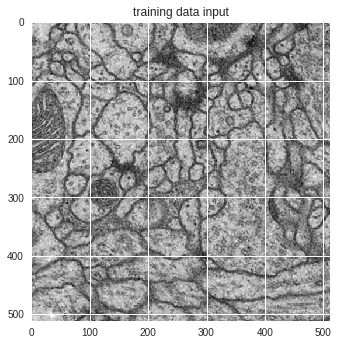

In [15]:

plt.imshow(train_images[0].reshape(512,512), interpolation='nearest', cmap='gray')
plt.title("training data input")
plt.show()

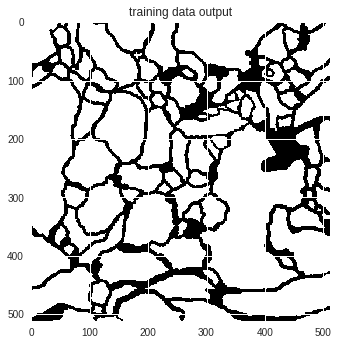

In [16]:
plt.imshow(train_label[0].reshape(512,512), interpolation='nearest', cmap='gray')
plt.title("training data output")
plt.show()

In [17]:
unet.fit(train_images, train_label, validation_data=
      (validation_image, validation_label), epochs=10,batch_size=1,shuffle=True,)
unet.save('Unet2.h5')

Instructions for updating:
Use tf.cast instead.
Train on 15 samples, validate on 14 samples
Epoch 1/10
15/15 [==============================] - 11s 721ms/step - loss: 55543.1461 - val_loss: 51655.2115
Epoch 2/10
15/15 [==============================] - 4s 249ms/step - loss: 48537.8096 - val_loss: 44292.1847
Epoch 3/10
15/15 [==============================] - 4s 250ms/step - loss: 40337.2891 - val_loss: 34149.1984
Epoch 4/10
15/15 [==============================] - 4s 249ms/step - loss: 25709.0211 - val_loss: 14049.9261
Epoch 5/10
15/15 [==============================] - 4s 249ms/step - loss: 13988.9645 - val_loss: 12839.3549
Epoch 6/10
15/15 [==============================] - 4s 249ms/step - loss: 12550.0052 - val_loss: 12449.2244
Epoch 7/10
15/15 [==============================] - 4s 249ms/step - loss: 12094.8741 - val_loss: 12303.6888
Epoch 8/10
15/15 [==============================] - 4s 249ms/step - loss: 11888.7257 - val_loss: 12270.9784
Epoch 9/10
15/15 [=========================

In [0]:
#unet.load_weights('Unet2.h5')

(30, 512, 512)


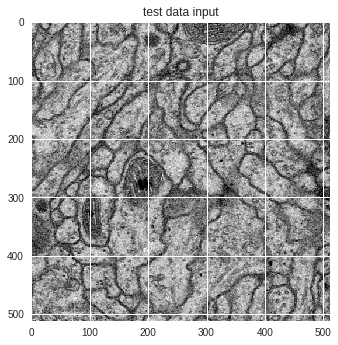

In [19]:
print(test_info.shape)
plt.imshow(test_info[0].reshape(512,512), interpolation='nearest', cmap='gray')
plt.title("test data input")
plt.show()

In [20]:
test_info = test_info.reshape(test_info.shape[0],512,512,1)
print(test_info.shape)
print(str(type(test_info)))

(30, 512, 512, 1)
<class 'numpy.ndarray'>


In [0]:
prediction = unet.predict(test_info, batch_size =1)

In [22]:
print("prediction shape: " + str(prediction.shape))
print(str(type(prediction)))
print("prediction[0] shape: " + str(prediction[0].shape))

prediction shape: (30, 512, 512, 1)
<class 'numpy.ndarray'>
prediction[0] shape: (512, 512, 1)


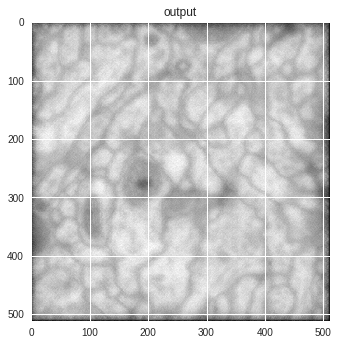

In [23]:
test_label = prediction[0]
test_label = test_label.reshape(512,512)
plt.imshow(test_label ,cmap='gray')
plt.title("output")
plt.show()

In [26]:
Test_Input = test_info[0]
print(str(Test_Input.shape))
Test_Input = Test_Input.reshape(512,512)

(512, 512, 1)


In [27]:
Test_Output = prediction[0]
print(str(Test_Output.shape))
Test_Output = Test_Output.reshape(512,512)

(512, 512, 1)


In [28]:
difference = 0

for i in range(test_info.shape[0]):
    for j in range(test_info.shape[0]):
        difference = Test_Input[i][j] - Test_Output[i][j]
        
        
print(str(difference))

-31.703156


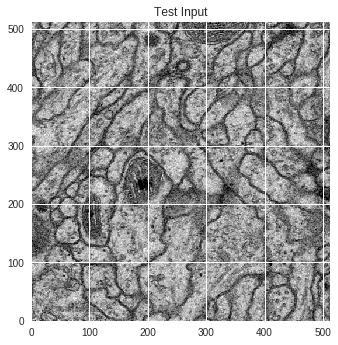

In [29]:
extent = 0, 512, 0, 512
plt.imshow(Test_Input,cmap ='gray', interpolation='nearest',
                 extent=extent)
plt.title("Test Input")
plt.show()

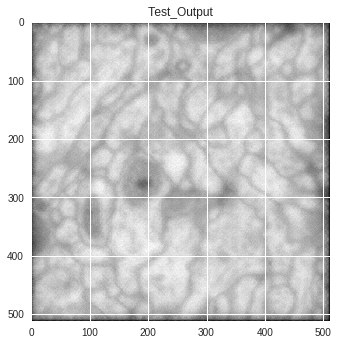

In [30]:
plt.imshow(Test_Output.reshape(512,512), cmap='gray')
plt.title("Test_Output")
plt.show()

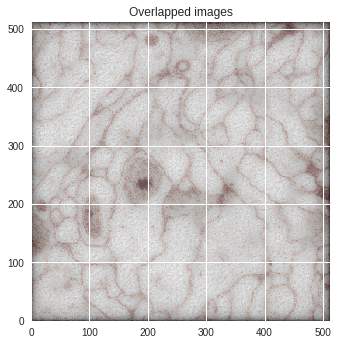

In [31]:
plt.imshow(Test_Input, cmap='RdGy', interpolation='nearest',
                 extent=extent)
plt.imshow(Test_Output, cmap='gray', alpha=.8, interpolation='bilinear',
                 extent=extent)
plt.title("Overlapped images")
plt.show()
plt.show()